In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc
from dash import html
from dash import Input, Output
import plotly.express as px
import numpy as np

In [4]:
df = pd.read_csv('https://www.dubaipulse.gov.ae/dataset/c9263194-5ee3-4340-b7c0-3269b26acb43/resource/c3ece154-3071-4116-8650-e769d8416d88/download/traffic_incidents.csv')
df.head(5)

,acci_id,acci_time,acci_name,acci_x,acci_y
0,4530649405,28/05/2024 21:31:14,الوقوف خلف المركبات (دبل بارك) - بسيط,25.270020,55.375510
1,4530696968,28/05/2024 22:45:56,حيوانات سائبة على الطريق العام - بسيط,24.779833,55.598657
2,4530698230,28/05/2024 22:47:58,صدم رصيف - بسيط,25.274576,55.376645
3,4530700793,28/05/2024 22:52:01,الوقوف خلف المركبات (دبل بارك) - بسيط,25.169339,55.253313
4,4530712496,28/05/2024 23:10:07,اصطدام بين عدة مركبات - بسيط,25.278320,55.422570


In [5]:
df['severity'] = df['acci_name'].str.split('-').str[1] # extract accident severity from accident time column

In [6]:
df.dropna(inplace=True)

In [7]:
df.head()

,acci_id,acci_time,acci_name,acci_x,acci_y,severity
0,4530649405,28/05/2024 21:31:14,الوقوف خلف المركبات (دبل بارك) - بسيط,25.270020,55.375510,بسيط
1,4530696968,28/05/2024 22:45:56,حيوانات سائبة على الطريق العام - بسيط,24.779833,55.598657,بسيط
2,4530698230,28/05/2024 22:47:58,صدم رصيف - بسيط,25.274576,55.376645,بسيط
3,4530700793,28/05/2024 22:52:01,الوقوف خلف المركبات (دبل بارك) - بسيط,25.169339,55.253313,بسيط
4,4530712496,28/05/2024 23:10:07,اصطدام بين عدة مركبات - بسيط,25.278320,55.422570,بسيط


In [8]:
# Cleaning data and creating GeoDataFrame
df['acci_time'] = pd.to_datetime(df['acci_time'], dayfirst=True)
df['hour'] = df['acci_time'].dt.hour
df['day_of_week'] = df['acci_time'].dt.day_name()
df['year'] = df['acci_time'].dt.year
df['month'] = df['acci_time'].dt.month
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.acci_y, df.acci_x))

In [9]:
gdf.head()

,acci_id,acci_time,acci_name,acci_x,acci_y,severity,hour,day_of_week,year,month,geometry
0,4530649405,2024-05-28 21:31:14,الوقوف خلف المركبات (دبل بارك) - بسيط,25.270020,55.375510,بسيط,21,Tuesday,2024,5,POINT (55.37551 25.27002)
1,4530696968,2024-05-28 22:45:56,حيوانات سائبة على الطريق العام - بسيط,24.779833,55.598657,بسيط,22,Tuesday,2024,5,POINT (55.59866 24.77983)
2,4530698230,2024-05-28 22:47:58,صدم رصيف - بسيط,25.274576,55.376645,بسيط,22,Tuesday,2024,5,POINT (55.37665 25.27458)
3,4530700793,2024-05-28 22:52:01,الوقوف خلف المركبات (دبل بارك) - بسيط,25.169339,55.253313,بسيط,22,Tuesday,2024,5,POINT (55.25331 25.16934)
4,4530712496,2024-05-28 23:10:07,اصطدام بين عدة مركبات - بسيط,25.278320,55.422570,بسيط,23,Tuesday,2024,5,POINT (55.42257 25.27832)


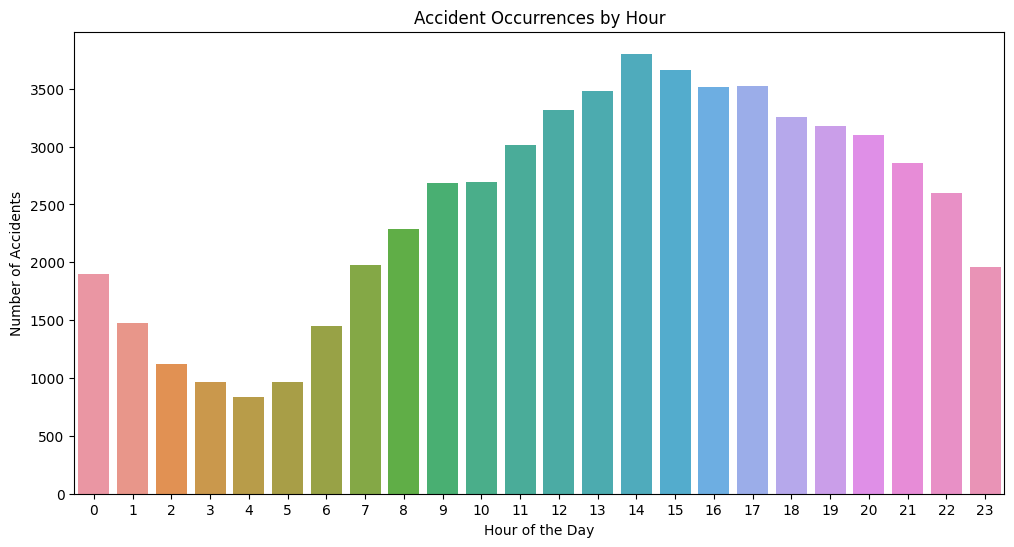

In [10]:
#overall plot of number of accidents per hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=df)
plt.title('Accident Occurrences by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()

# An interactive dashboard to visualize accidents by time of day, month, and severity

In [11]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Traffic Accidents Dashboard"),
    
    dcc.Dropdown(
        id='time-period',
        options=[
            {'label': 'Morning (6am - 12pm)', 'value': 'morning'},
            {'label': 'Afternoon (12pm - 6pm)', 'value': 'afternoon'},
            {'label': 'Evening (6pm - 12am)', 'value': 'evening'},
            {'label': 'Night (12am - 6am)', 'value': 'night'},
        ],
        value=['morning', 'afternoon', 'evening', 'night'],
        multi=True,
        placeholder="Select time period(s)"
    ),
    
    dcc.Dropdown(
        id='severity',
        options=[
            {'label': 'Low Severity', 'value': ' Low'},
            {'label': 'High Severity', 'value': ' High'},
            {'label': 'Both', 'value': 'both'}
        ],
        value='both',
        placeholder="Select severity"
    ),
    
    dcc.Dropdown(
        id='month-year',
        multi=True,
        placeholder="Select month(s) and year(s)"
    ),
    
    dcc.Graph(id='map-graph')
])

@app.callback(
    Output('month-year', 'options'),
    [Input('time-period', 'value'),
     Input('severity', 'value')]
)
def populate_month_year_dropdown(time_periods, severity):
    # Filter DataFrame based on selected time periods
    filtered_df = df[df['hour'].isin(get_hours_for_time_periods(time_periods))]
    
    # Filter DataFrame based on selected severity
    if severity != 'both':
        filtered_df = filtered_df[filtered_df['severity'] == severity]
    

    unique_years_months = filtered_df['acci_time'].dt.strftime('%Y-%m').unique()
    
    # Generate unique options for dropdown
    options = [{'label': f"{ym}", 'value': f"{ym}"} for ym in unique_years_months]
    
    return options

@app.callback(
    Output('map-graph', 'figure'),
    [Input('time-period', 'value'),
     Input('severity', 'value'),
     Input('month-year', 'value')]
)
def update_map(time_periods, severity, month_years):

    filtered_df = df[df['hour'].isin(get_hours_for_time_periods(time_periods))]

    if severity != 'both':
        filtered_df = filtered_df[filtered_df['severity'] == severity]
    
    if month_years:
        filtered_df = filtered_df[filtered_df['acci_time'].dt.strftime('%Y-%m').isin(month_years)]
    
    fig = px.scatter_mapbox(filtered_df, lat='acci_x', lon='acci_y', color='severity',
                            mapbox_style="carto-positron", zoom=10)
    
    return fig

def get_hours_for_time_periods(time_periods):
    hours = []
    if 'morning' in time_periods:
        hours += list(range(6, 12))
    if 'afternoon' in time_periods:
        hours += list(range(12, 18))
    if 'evening' in time_periods:
        hours += list(range(18, 24))
    if 'night' in time_periods:
        hours += list(range(0, 6))
    return hours

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\mohan\AppData\Roaming\Python\Python310\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\mohan\AppData\Roaming\Python\Python310\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\mohan\AppData\Roaming\Python\Python310\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\mohan\AppData\Roaming\Python\Python310\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with 